# Simple kNN scores LB 0.938 in 30 seconds!
In this notebook, we build a simple model using [Nvidia RAPIDS][1] cuML's blazingly fast kNN algorithm. The high CV and LB of this model confirms the simple nature of Kaggle's Ion Switching competition data. We will be using this competition's cleaned dataset posted [here][2]. So this notebook also shows that the clean dataset is infact very clean. Feel free to use the clean dataset in your future notebooks and don't forget to upvote the clean dataset :-) The clean dataset uses Markus' great cleaning method [here][3].

[1]: https://rapids.ai/
[2]: https://www.kaggle.com/cdeotte/data-without-drift
[3]: https://www.kaggle.com/friedchips/clean-removal-of-data-drift

# Install RAPIDS 0.12.0

In [1]:
import sys
!cp ../input/rapids/rapids.0.12.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.6/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.6"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.stats import mode
from sklearn.metrics import f1_score, accuracy_score
import lightgbm as lgb
#from cuml.neighbors import KNeighborsClassifier, NearestNeighbors
#import cuml; cuml.__version__

'0.12.0'

# Load Clean Competition Data
We will use the Kaggle dataset [here][1] containing this competition's train and test data with drift removed. Drift is explained [here][2]. And visualized [here][3]. This competition's data is believed to be `data = computer generated + real life noise + synthetic drift`. Drift was found in training data batches 2, 7, 8, 9, 10. And test batches 1, 2, 3. [Markus][5] demonstrated in his great notebook [here][4] that drift can be cleanly removed with 4th order approximation functions. 

Clean data allows to produce better EDA and allows us to use models like kNN.

[1]: https://www.kaggle.com/cdeotte/data-without-drift
[2]: https://www.kaggle.com/c/liverpool-ion-switching/discussion/133874
[3]: https://www.kaggle.com/cdeotte/one-feature-model-0-930
[4]: https://www.kaggle.com/friedchips/clean-removal-of-data-drift
[5]: https://www.kaggle.com/friedchips

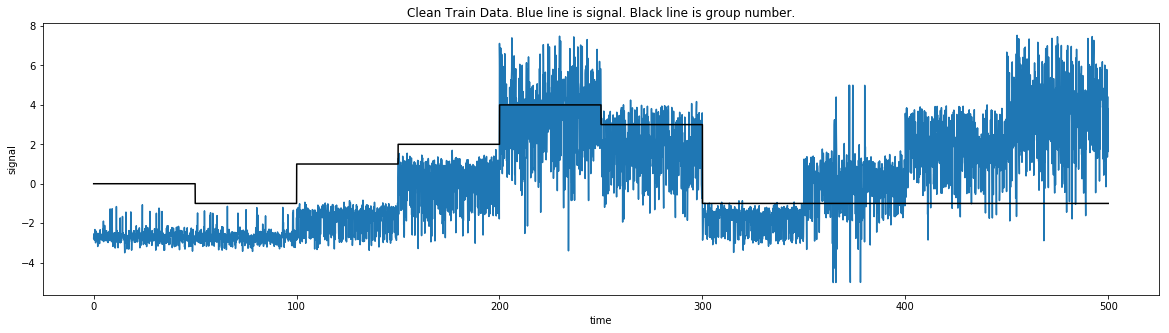

In [3]:
train = pd.read_csv('/kaggle/input/data-without-drift/train_clean.csv')
train['group'] = -1
x = [(0,500000),(1000000,1500000),(1500000,2000000),(2500000,3000000),(2000000,2500000)]
for k in range(5): train.iloc[x[k][0]:x[k][1],3] = k
    
res = 1000
plt.figure(figsize=(20,5))
plt.plot(train.time[::res],train.signal[::res])
plt.plot(train.time,train.group,color='black')
plt.title('Clean Train Data. Blue line is signal. Black line is group number.')
plt.xlabel('time'); plt.ylabel('signal')
plt.show()

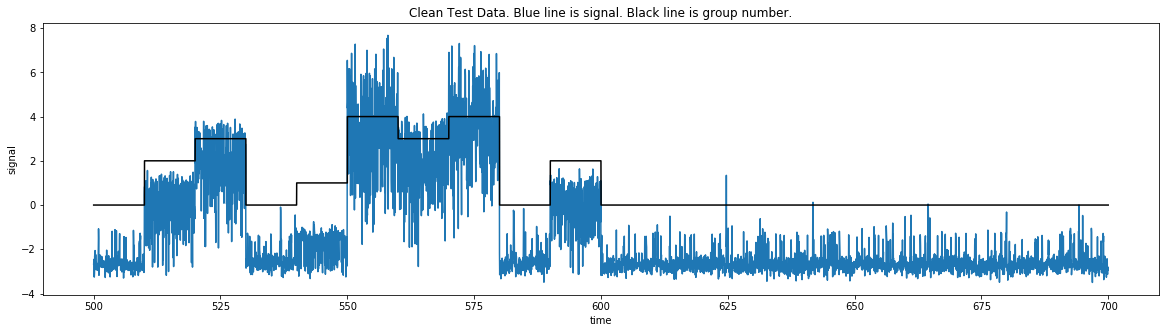

In [4]:
test = pd.read_csv('/kaggle/input/data-without-drift/test_clean.csv')
test['group'] = -1
x = [[(0,100000),(300000,400000),(800000,900000),(1000000,2000000)],[(400000,500000)], 
     [(100000,200000),(900000,1000000)],[(200000,300000),(600000,700000)],[(500000,600000),(700000,800000)]]
for k in range(5):
    for j in range(len(x[k])): test.iloc[x[k][j][0]:x[k][j][1],2] = k
        
res = 400
plt.figure(figsize=(20,5))
plt.plot(test.time[::res],test.signal[::res])
plt.plot(test.time,test.group,color='black')
plt.title('Clean Test Data. Blue line is signal. Black line is group number.')
plt.xlabel('time'); plt.ylabel('signal')
plt.show()

# One Feature Model
With clean data, we can now make a one feature model. A full explanation of the one feature model is [here][1]. Summary of one feature model is below. If you have an unknown test row, then first you determine which group that row belongs to. Next you find the signal from that row on the x axis below and find the corresponding open channels prediction on the y axis below. This model has CV 0.926 and LB 0.929.

[1]: https://www.kaggle.com/cdeotte/one-feature-model-0-930

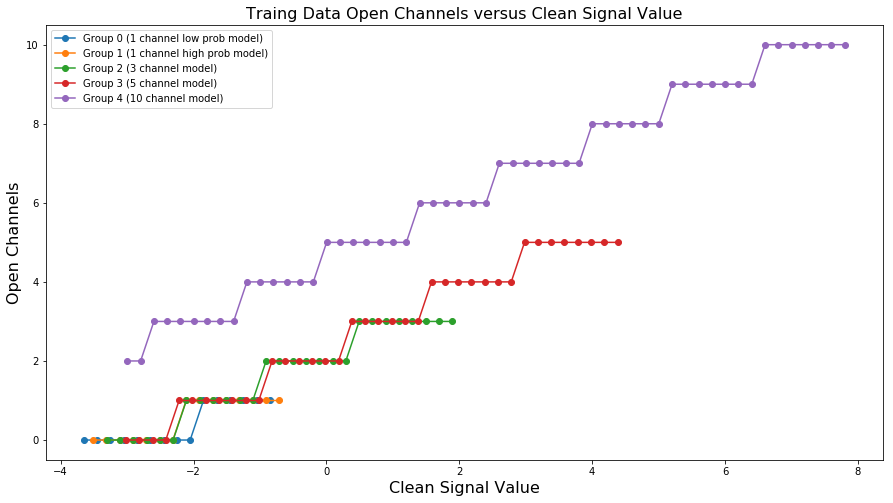

In [5]:
step = 0.2
pt = [[],[],[],[],[]]
cuts = [[],[],[],[],[]]
for g in range(5):
    mn = train.loc[train.group==g].signal.min()
    mx = train.loc[train.group==g].signal.max()
    old = 0
    for x in np.arange(mn,mx+step,step):
        sg = train.loc[(train.group==g)&(train.signal>x-step/2)&(train.signal<x+step/2)].open_channels.values
        if len(sg)>100:
            m = mode(sg)[0][0]
            pt[g].append((x,m))
            if m!=old: cuts[g].append(x-step/2)
            old = m
    pt[g] = np.vstack(pt[g])
    
models = ['1 channel low prob','1 channel high prob','3 channel','5 channel','10 channel']
plt.figure(figsize=(15,8))
for g in range(5):
    plt.plot(pt[g][:,0],pt[g][:,1],'-o',label='Group %i (%s model)'%(g,models[g]))
plt.legend()
plt.title('Traing Data Open Channels versus Clean Signal Value',size=16)
plt.xlabel('Clean Signal Value',size=16)
plt.ylabel('Open Channels',size=16)
plt.show()

# Two Feature Model
We can improve the one feature model by adding a second feature. For every unknown test row, we will also use the preceeding row's signal value. This model has CV 0.9295 and LB 0.932. Below are plots of the two feature model. When given an unknown test row. Just find the most similar training row that has the same signal and preceeding row signal.

Specifically, here is how to use the plots below to predict an unknown test row. First determine what group the test row is in and find the corresponding group plots below. Next match the signal to the y axis and the preceeding row's signal to the x axis. Whatever color is beneath your point is the number of open channels you will predict.

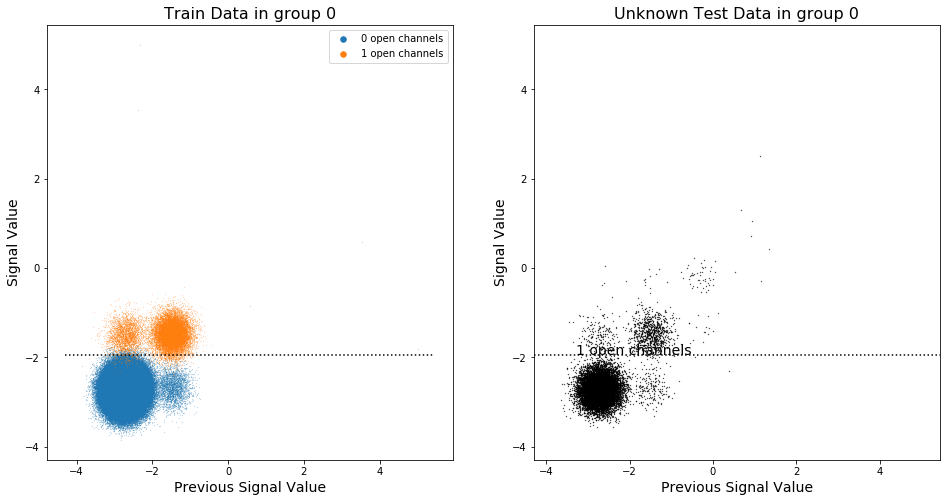

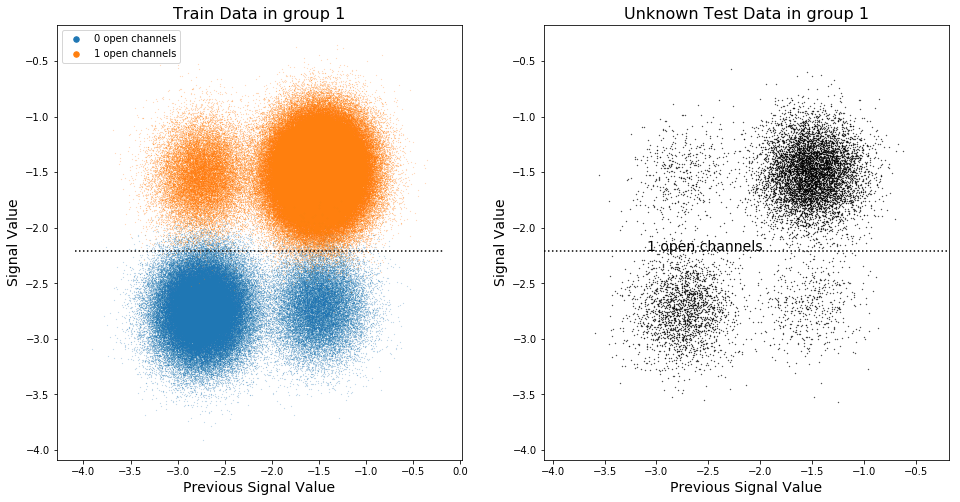

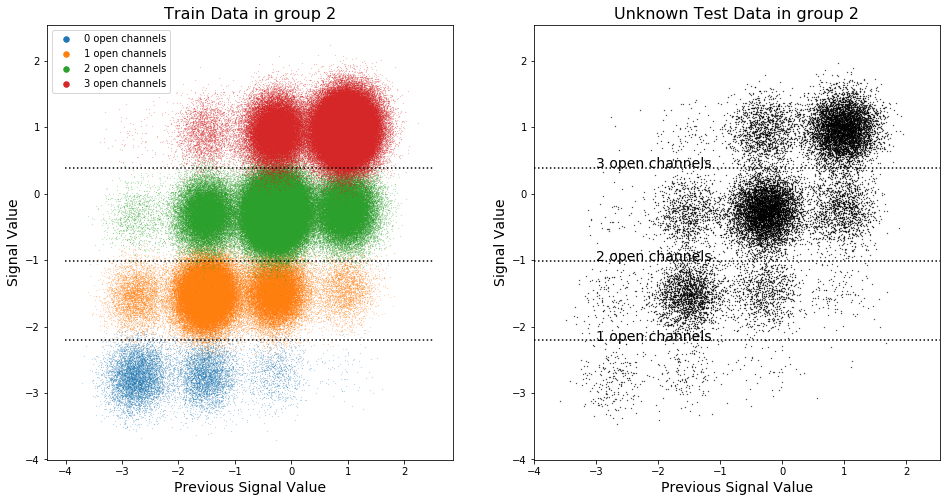

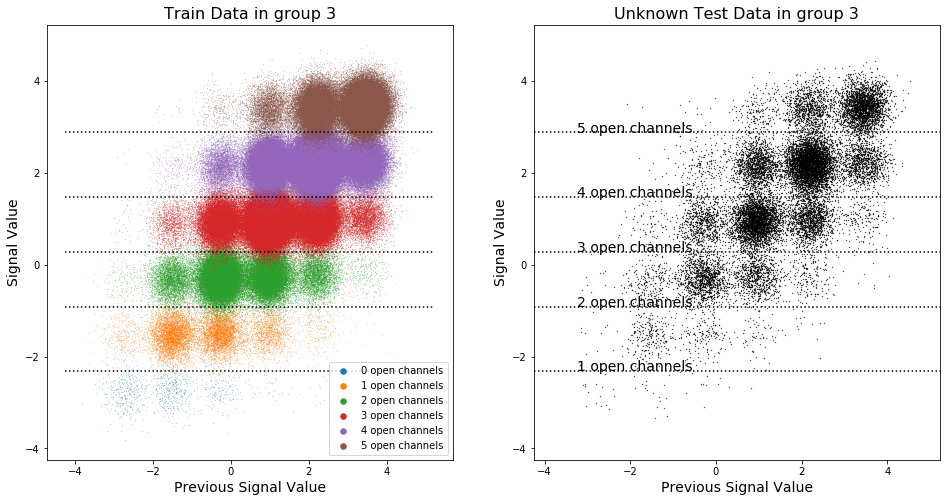

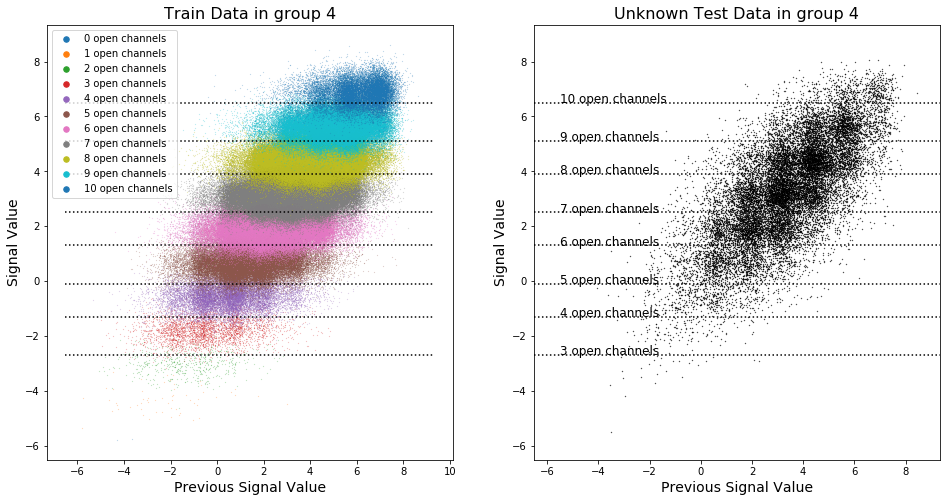

In [6]:
import warnings
warnings.filterwarnings("ignore")
for g in range(5):
    if g==0: res = 100
    else: res = 10

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    for k in range(0,11):
        idx = np.array( train.loc[(train.open_channels==k) & (train.group==g)].index )
        if len(idx)==0: continue
        plt.scatter(train.signal[idx-1],train.signal[idx],s=0.01,label='%i open channels'%k)
    plt.xlabel('Previous Signal Value',size=14)
    plt.ylabel('Signal Value',size=14)
    lgnd = plt.legend(numpoints=1, fontsize=10)
    for k in range( len(lgnd.legendHandles) ):
        lgnd.legendHandles[k]._sizes = [30]
    
    data = test.loc[test.group==g]
    #plt.scatter(data.signal[:-1][::res],data.signal[1:][::res],s=0.1,color='black')
    xx = plt.xlim(); yy = plt.ylim()
    for k in range(len(cuts[g])):
        if (g!=4)|(k!=0): plt.plot([xx[0],xx[1]],[cuts[g][k],cuts[g][k]],':',color='black')
    plt.title('Train Data in group %i'%g,size=16)
    
    plt.subplot(1,2,2)
    plt.scatter(data.signal[:-1][::res],data.signal[1:][::res],s=0.1,color='black')
    plt.xlim(xx); plt.ylim(yy)
    for k in range(len(cuts[g])):
        if (g!=4)|(k!=0): plt.plot([xx[0],xx[1]],[cuts[g][k],cuts[g][k]],':',color='black')
        if (g==4)&(k!=0): plt.text(xx[0]+1,cuts[g][k],'%i open channels'%(k+2),size=12)
        elif g!=4: plt.text(xx[0]+1,cuts[g][k],'%i open channels'%(k+1),size=14)
    plt.xlabel('Previous Signal Value',size=14)
    plt.ylabel('Signal Value',size=14)
    plt.title('Unknown Test Data in group %i'%g,size=16)

    plt.show()

# Seven Feature Model
Now if we wish to predict a row of the test data, we will use the three rows before and three rows after. In total we will use 7 features. We will use simple kNN compared with the train data. We can visualize a row of test data as a "wiggle". The green dot is the unknown test row and it's signal value can be found on the y axis. The red dots are the 3 rows before and the blue dots are the 3 rows after. Given a unknown test data "wiggle", our job is to find the most similar looking training data "wiggle".

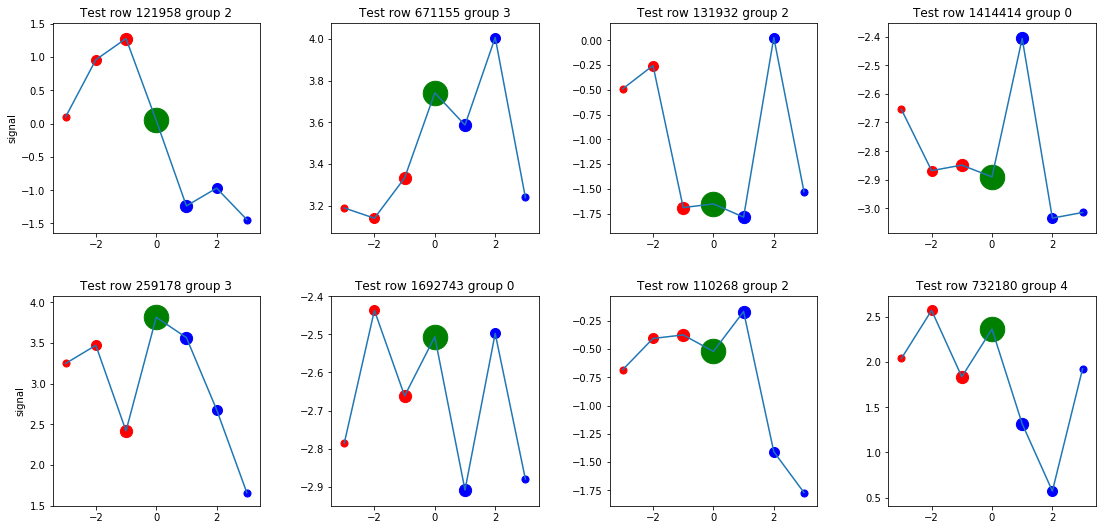

In [7]:
def wiggle(df, row, plt, xx=None, yy=None):
    plt.plot([-3,-2,-1,0,1,2,3],df.loc[df.index[row-3:row+4],'signal'],'-')
    sizes = np.array([1,2,3,12,3,2,1])*50
    colors = ['red','red','red','green','blue','blue','blue']
    for k in range(7):
        plt.scatter(k-3,df.loc[df.index[row+k-3],'signal'],s=sizes[k],color=colors[k])
    if xx!=None: plt.xlim(xx)
    if yy!=None: plt.ylim(yy)
    return plt.xlim(),plt.ylim()

row=2; col=4;
np.random.seed(42)
plt.figure(figsize=(4*col,4*row))
for k in range(row*col):
    plt.subplot(row,col,k+1)
    r = np.random.randint(2e6)
    wiggle(test,r,plt)
    if k%col==0: plt.ylabel('signal')
    g = test.loc[r,'group']
    plt.title('Test row %i group %i'%(r,g))
plt.tight_layout(pad=3.0)
plt.show()

# RAPIDS cuML GPU kNN
Given an unknown test "wiggle" we need to search all 500,000 "wiggles" from the train data's similar group. That's a lot of kNN searching. If we use CPU, this will takes days! With GPU we can predict all the 2,000,000 (two million) unknown test data in 30 seconds. We need to compare each unknown test row with 500,000 (five hundred thousand) train rows. So that is 1,000,000,000,000 (one trillion) comparisons!

Normally, we would use three RAPIDS cuML function calls. Normally we call `model = KNeighborsClassifier(n_neighbors=KNN)` then `model.fit(X_train,y_train)` and finally `y_hat = model.predict(X_test)`. However RAPIDS is under development and the current version 0.12.0 of RAPIDS throws some errors when we do that. So instead we will call `model = NearestNeighbors(n_neighbors=KNN)` then `model.fit(X_train)` and finally `distances, indices = model.kneighbors(X_test)`. This returns all the neighbors successfully. With the neighbors, we then use `np.median()` on neighbors' open channels to find the prediction.

In [8]:
%%time

KNN = 100
batch = 1000

test_pred = np.zeros((test.shape[0]),dtype=np.int8)
for g in [0,1,2,3,4]:
    print('Infering group %i'%g)
    
    # TRAIN DATA
    data = train.loc[train.group==g]
    X_train = np.zeros((len(data)-6,7))
    X_train[:,0] = 0.25*data.signal[:-6]
    X_train[:,1] = 0.5*data.signal[1:-5]
    X_train[:,2] = 1.0*data.signal[2:-4]
    X_train[:,3] = 4.0*data.signal[3:-3]
    X_train[:,4] = 1.0*data.signal[4:-2]
    X_train[:,5] = 0.5*data.signal[5:-1]
    X_train[:,6] = 0.25*data.signal[6:]
    y_train = data.open_channels[3:].values

    # TEST DATA
    data = test.loc[test.group==g]
    X_test = np.zeros((len(data)-6,7))
    X_test[:,0] = 0.25*data.signal[:-6]
    X_test[:,1] = 0.5*data.signal[1:-5]
    X_test[:,2] = 1.0*data.signal[2:-4]
    X_test[:,3] = 4.0*data.signal[3:-3]
    X_test[:,4] = 1.0*data.signal[4:-2]
    X_test[:,5] = 0.5*data.signal[5:-1]
    X_test[:,6] = 0.25*data.signal[6:]

    # HERE IS THE CORRECT WAY TO USE CUML KNN 
    #model = KNeighborsClassifier(n_neighbors=KNN)
    #model.fit(X_train,y_train)
    #y_hat = model.predict(X_test)
    #test_pred[test.group==g][1:-1] = y_hat
    #continue
    
    # WE DO THIS BECAUSE CUML v0.12.0 HAS A BUG
    model = NearestNeighbors(n_neighbors=KNN)
    model.fit(X_train)
    distances, indices = model.kneighbors(X_test)

    # FIND PREDICTIONS OURSELVES WITH STATS.MODE
    ct = indices.shape[0]
    pred = np.zeros((ct+6),dtype=np.int8)
    it = ct//batch + int(ct%batch!=0)
    #print('Processing %i batches:'%(it))
    for k in range(it):
        a = batch*k; b = batch*(k+1); b = min(ct,b)
        pred[a+3:b+3] = np.median( y_train[ indices[a:b].astype(int) ], axis=1)
        #print(k,', ',end='')
    #print()
    test_pred[test.group==g] = pred

Infering group 0
Infering group 1
Infering group 2
Infering group 3
Infering group 4
CPU times: user 19.5 s, sys: 13.4 s, total: 32.9 s
Wall time: 33.5 s


# Visualize kNN
Below are some random rows from test data group 4 and the 4 closest kNN training rows. We then use the most common known training label to predict the unknown test label.

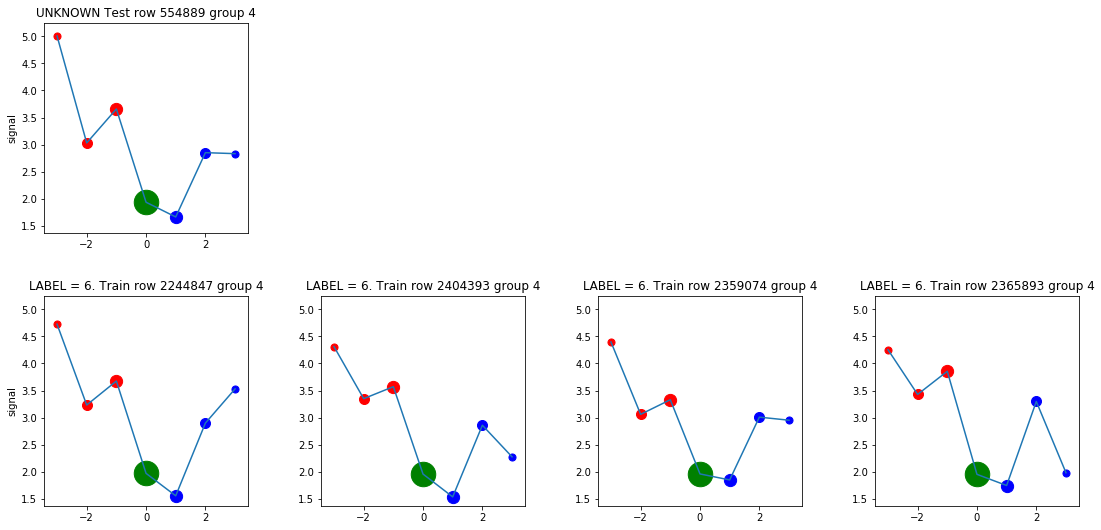

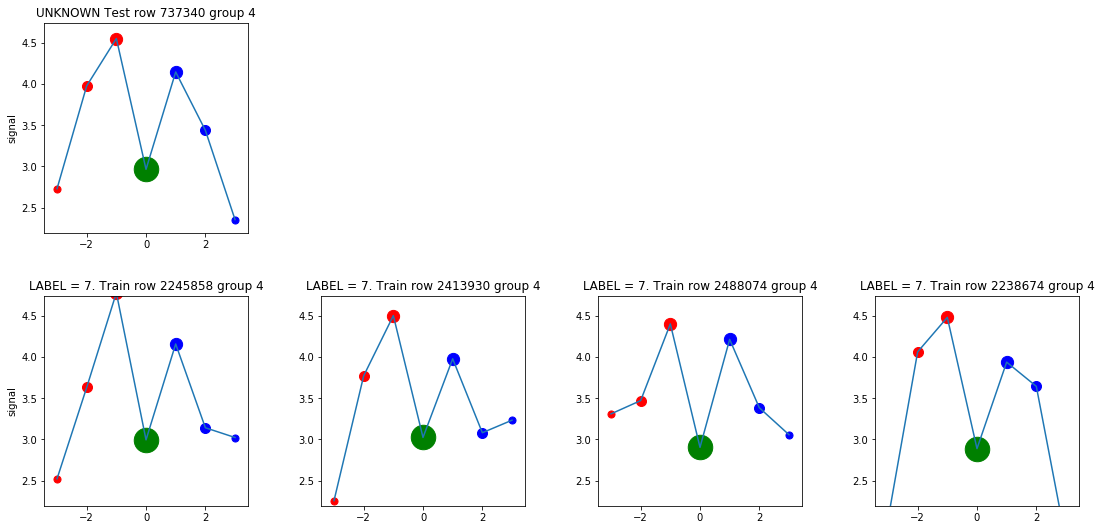

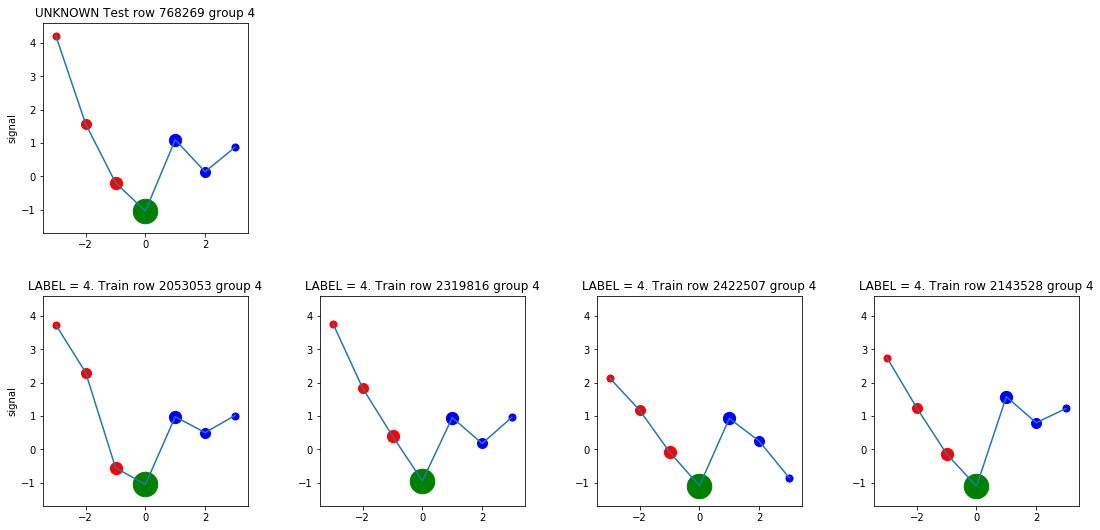

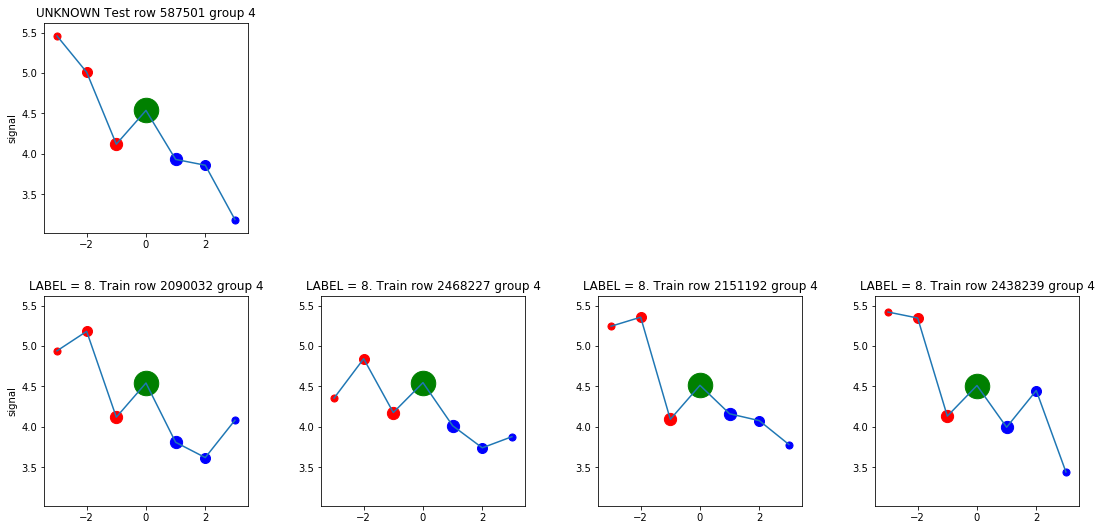

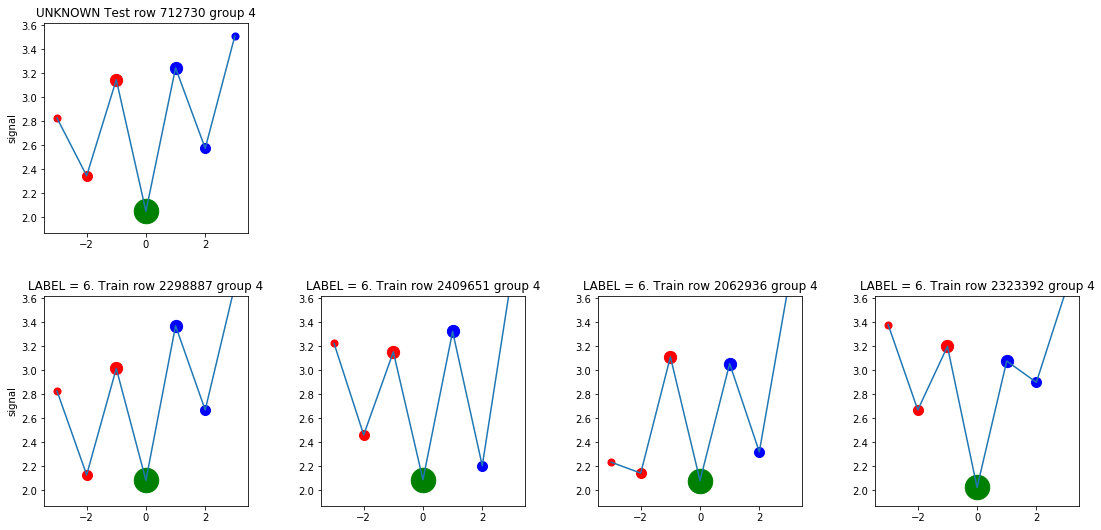

In [9]:
data1 = test.loc[test.group==4].iloc[3:]
data1.reset_index(inplace=True)

data2 = train.loc[train.group==4].iloc[3:]
data2.reset_index(inplace=True)

for j in range(5):
    r = np.random.randint(data1.shape[0])
    distances, indices = model.kneighbors(X_test[r:r+1,])

    row=2; 
    plt.figure(figsize=(16,row*4))
    for k in range(row*4):
        if k in [1,2,3]: continue
        plt.subplot(row,4,k+1)
        if k==0: 
            xx,yy = wiggle(data1,r,plt)
            g = data1.loc[r,'group']
            rw = data1.loc[r,'index']
            plt.title('UNKNOWN Test row %i group %i'%(rw,g))
        else:
            r=indices[0,k-4].astype('int')
            wiggle(data2,r,plt,xx,yy)
            g = data2.loc[r,'group']
            rw = data2.loc[r,'index']
            t = data2.loc[r,'open_channels']
            plt.title('LABEL = %i. Train row %i group %i'%(t,rw,g))
        if k%4==0: plt.ylabel('signal')
    plt.tight_layout(pad=3.0)
    plt.show()

# Export the Test Predictions

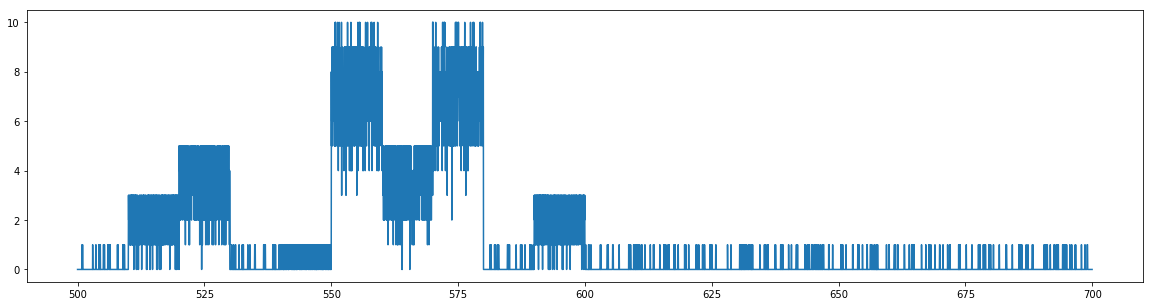

In [10]:
sub = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')
sub.open_channels = test_pred
sub.to_csv('submission.csv',index=False,float_format='%.4f')

res=200
plt.figure(figsize=(20,5))
plt.plot(sub.time[::res],sub.open_channels[::res])
plt.show()